# Proyek Predictive Analytics: Prediksi Risiko Stroke

- **Nama:** Javier Elian Putra Karjadi
- **Email:** mc325d5y0399@student.devacademy.id
- **Cohort ID:** MC325D5Y0399

## Domain Proyek: Kesehatan
Stroke adalah kondisi medis serius yang memerlukan deteksi dini untuk pencegahan yang efektif. Proyek ini bertujuan membangun model machine learning yang dapat memprediksi kemungkinan seseorang terkena stroke berdasarkan faktor-faktor seperti usia, riwayat penyakit, dan gaya hidup.

In [ ]:
# A. Import Library yang Dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Mengatur agar output menampilkan semua kolom
pd.set_option('display.max_columns', None)

## B. Data Loading
Tahap ini adalah proses memuat dataset ke dalam notebook untuk dianalisis lebih lanjut. Dataset yang digunakan adalah "Stroke Prediction Dataset" dari Kaggle.

In [ ]:
# Memuat data
df = pd.read_csv('stroke-prediction-dataset.csv')

# Menampilkan 5 baris pertama dari data
print("Data Awal:")
print(df.head())

Data Awal:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


## C. Exploratory Data Analysis (EDA) - Data Understanding
EDA adalah langkah krusial untuk memahami karakteristik, pola, anomali, dan distribusi data.

### C.1 Deskripsi Data
Melihat informasi dasar dataset seperti jumlah baris, kolom, tipe data, dan statistik deskriptif.

In [ ]:
# Informasi umum dataset
print("\nInformasi Dataset:")
df.info()

# Statistik deskriptif untuk fitur numerik
print("\nStatistik Deskriptif:")
print(df.describe())

# Memeriksa nilai yang hilang (missing values)
print("\nJumlah Missing Values:")
print(df.isnull().sum())


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Statistik Deskriptif:
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000   

### C.2 Analisis EDA
Dari pemeriksaan awal, ditemukan beberapa poin penting:
1.  Kolom `id` tidak relevan untuk pemodelan dan akan dihapus.
2.  Kolom `bmi` memiliki 201 nilai yang hilang.
3.  Kolom `gender` memiliki satu nilai 'Other' yang dapat dianggap sebagai anomali dan perlu ditangani.
4.  Target `stroke` sangat tidak seimbang (*imbalanced*).

Selanjutnya, kita akan melakukan visualisasi untuk memahami data lebih dalam.

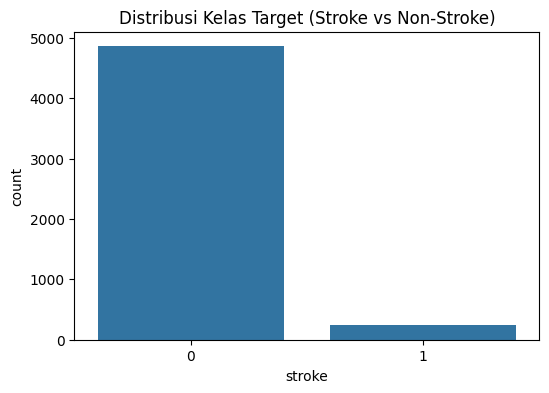

Jumlah Non-Stroke (0): 4861 (95.13%)
Jumlah Stroke (1): 249 (4.87%)


In [ ]:
# Visualisasi distribusi data target 'stroke'
plt.figure(figsize=(6, 4))
sns.countplot(x='stroke', data=df)
plt.title('Distribusi Kelas Target (Stroke vs Non-Stroke)')
plt.show()

# Menampilkan persentase
stroke_counts = df['stroke'].value_counts()
print(f"Jumlah Non-Stroke (0): {stroke_counts[0]} ({stroke_counts[0]/len(df)*100:.2f}%)")
print(f"Jumlah Stroke (1): {stroke_counts[1]} ({stroke_counts[1]/len(df)*100:.2f}%)")

Insight:

Visualisasi ini mengungkapkan adanya ketidakseimbangan kelas yang ekstrem dalam dataset. Jumlah pasien yang tidak mengalami stroke (kelas 0) jauh mendominasi dibandingkan pasien yang mengalami stroke (kelas 1, hanya ~5%). Insight penting dari temuan ini adalah bahwa model yang dilatih pada data ini tanpa penanganan khusus akan sangat cenderung memprediksi kelas mayoritas (non-stroke) untuk mencapai akurasi tinggi. Hal ini akan menyebabkan model gagal total dalam tujuan utamanya, yaitu mendeteksi kasus stroke yang langka namun kritis. Oleh karena itu, penerapan teknik penanganan data tidak seimbang seperti SMOTE menjadi langkah yang mutlak diperlukan.
Visualisasi ini mengungkapkan adanya ketidakseimbangan kelas yang ekstrem dalam dataset. Jumlah pasien yang tidak mengalami stroke (kelas 0) jauh mendominasi dibandingkan pasien yang mengalami stroke (kelas 1, hanya ~5%). Insight penting dari temuan ini adalah bahwa model yang dilatih pada data ini tanpa penanganan khusus akan sangat cenderung memprediksi kelas mayoritas (non-stroke) untuk mencapai akurasi tinggi. Hal ini akan menyebabkan model gagal total dalam tujuan utamanya, yaitu mendeteksi kasus stroke yang langka namun kritis. Oleh karena itu, penerapan teknik penanganan data tidak seimbang seperti SMOTE menjadi langkah yang mutlak diperlukan.

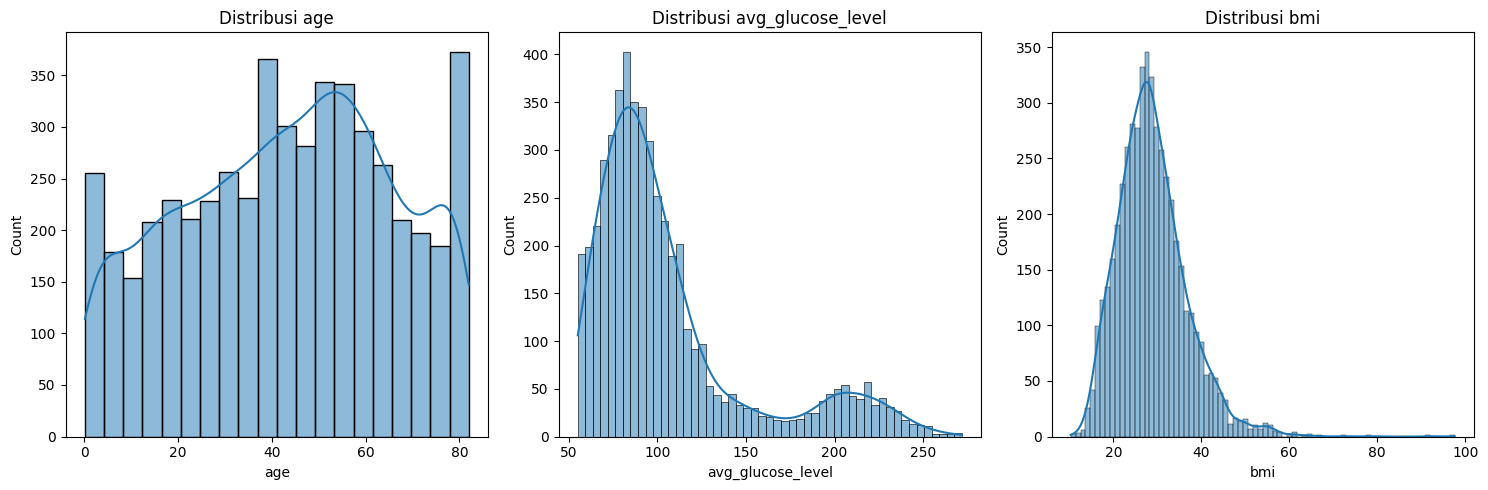

In [ ]:
# Visualisasi distribusi fitur numerik
numerical_features = ['age', 'avg_glucose_level', 'bmi']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribusi {feature}')
plt.tight_layout()
plt.show()

1. Fitur Numerik (Usia, Glukosa, BMI)
Usia (age): Distribusi pasien terkonsentrasi pada kelompok usia lanjut (40-80 tahun). Ini secara visual mengonfirmasi bahwa usia adalah faktor risiko utama stroke dalam dataset ini.
Kadar Glukosa (avg_glucose_level): Distribusinya memiliki dua puncak (bimodal), yang menandakan adanya dua kelompok pasien: mayoritas dengan glukosa normal dan minoritas dengan glukosa sangat tinggi (kemungkinan penderita diabetes). Ini menjadikannya faktor pembeda risiko yang jelas.
Indeks Massa Tubuh (bmi): Distribusinya condong ke kanan dengan puncak di kategori overweight. Ini menunjukkan bahwa kelebihan berat badan adalah kondisi umum dalam data ini dan menjadi faktor risiko penting.

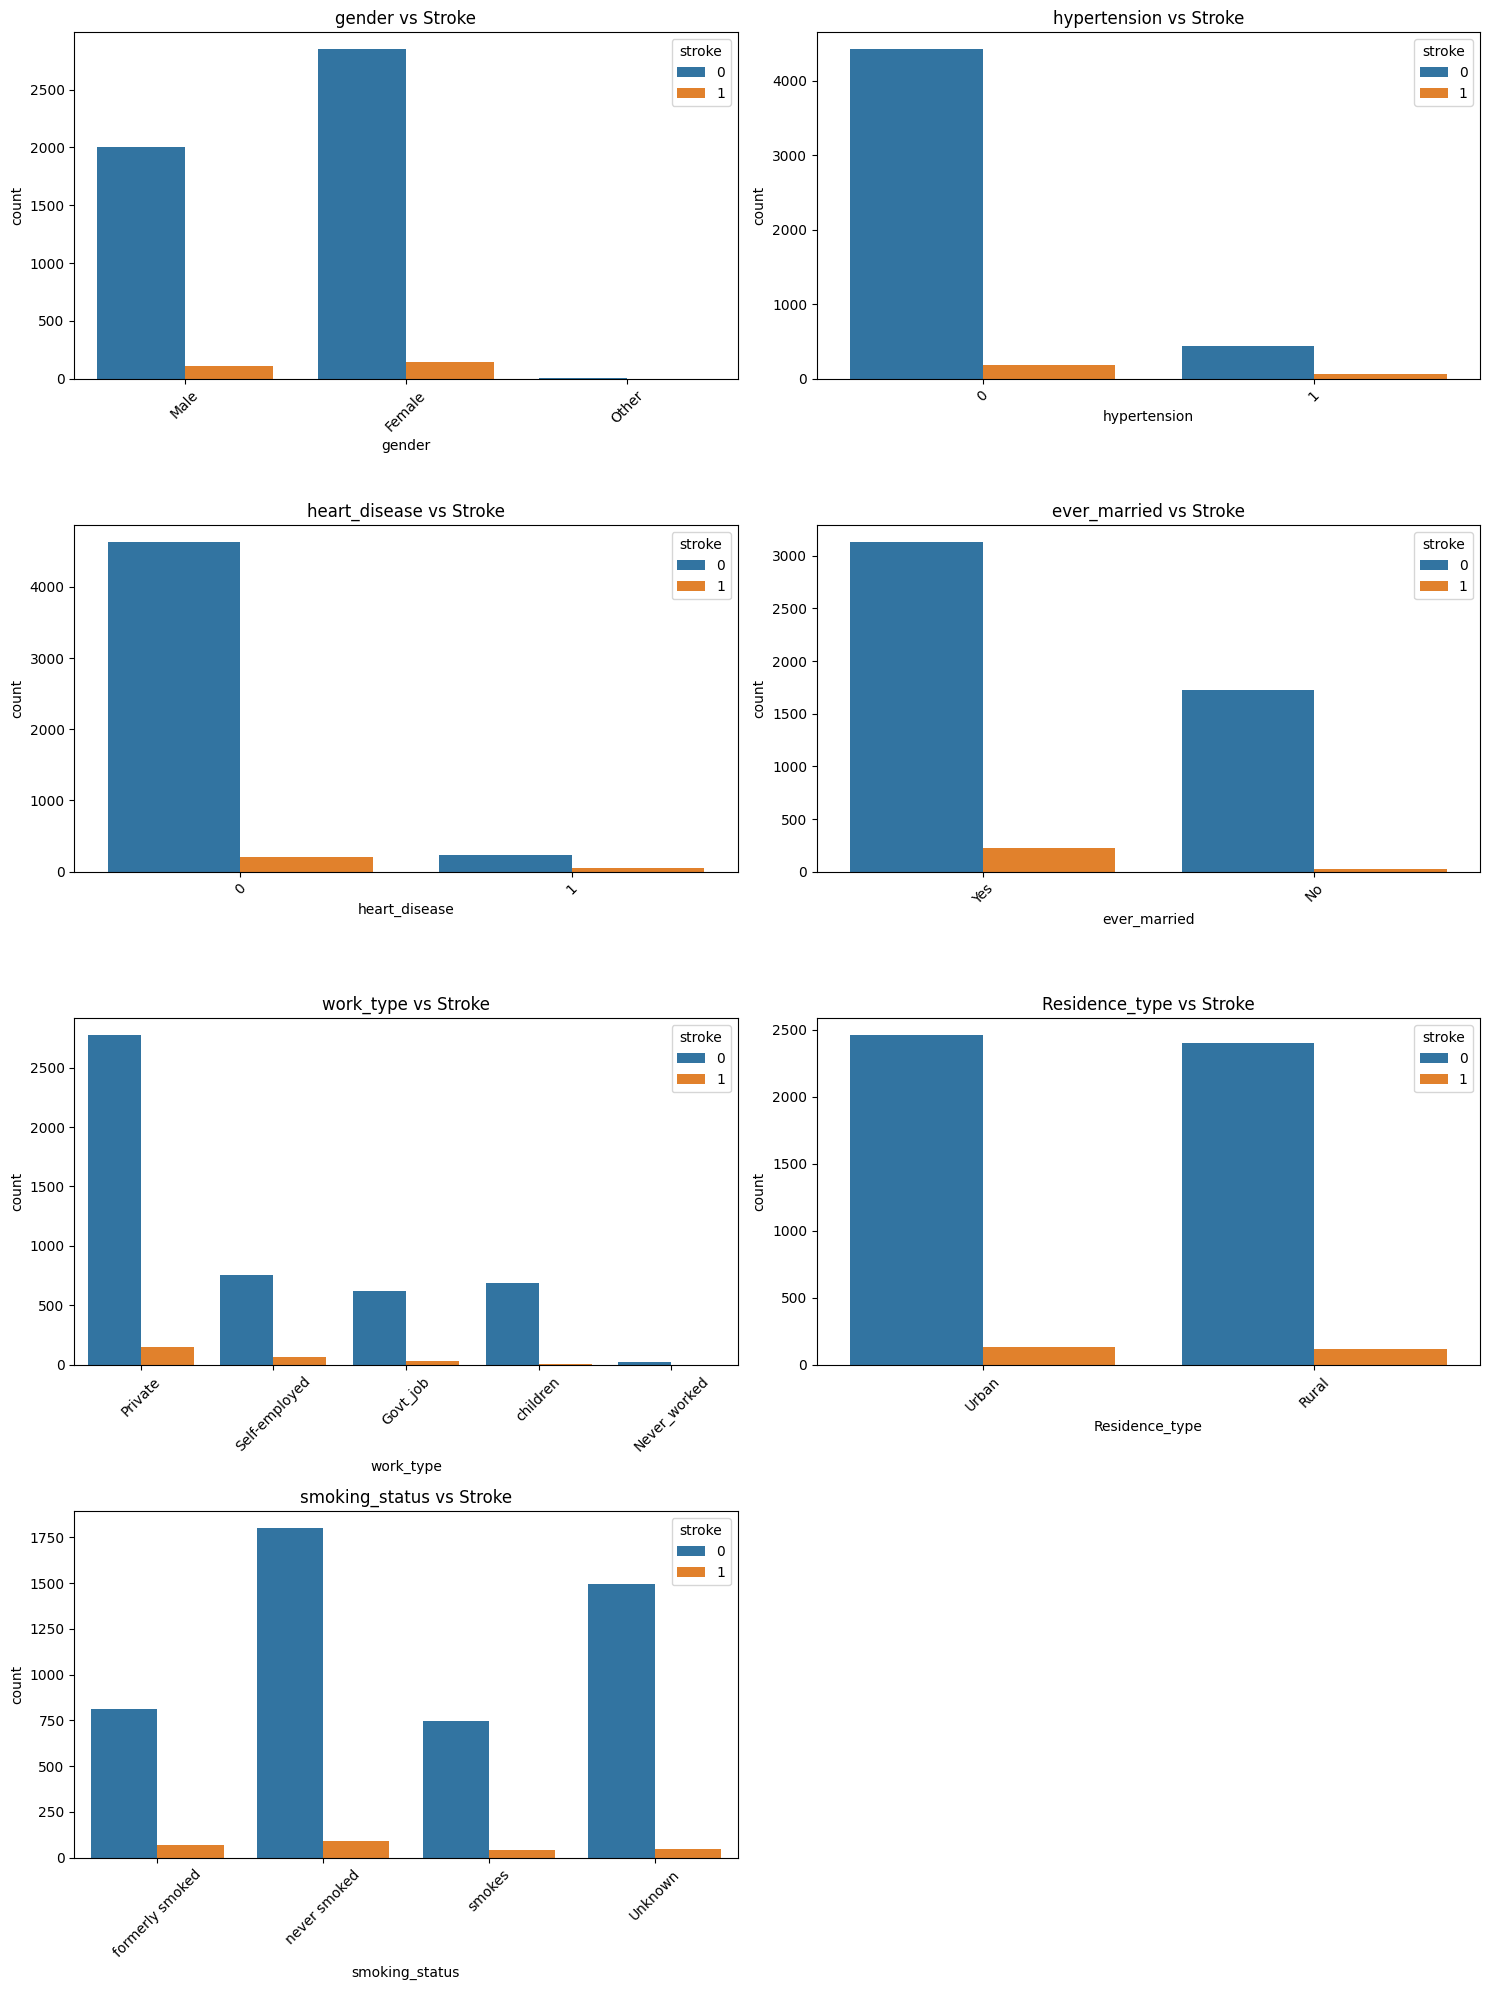

In [ ]:
# Visualisasi fitur kategorikal terhadap target 'stroke'
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
plt.figure(figsize=(15, 20))
for i, feature in enumerate(categorical_features):
    plt.subplot(4, 2, i+1)
    sns.countplot(x=feature, hue='stroke', data=df)
    plt.title(f'{feature} vs Stroke')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Fitur Kategorikal (Riwayat Medis, Gaya Hidup, Demografi)

Prediktor Kuat: Grafik untuk hipertensi, penyakit jantung, dan status merokok secara visual sangat kuat mengonfirmasi statusnya sebagai faktor risiko utama. Pasien dengan riwayat penyakit ini atau yang merokok/pernah merokok menunjukkan proporsi kejadian stroke yang jauh lebih tinggi.

Prediktor Terkorelasi: Pasien yang pernah menikah dan yang bekerja di sektor swasta/wiraswasta juga menunjukkan rasio stroke yang lebih tinggi. Namun, temuan ini kemungkinan besar adalah korelasi tidak langsung yang sangat dipengaruhi oleh faktor usia.

Prediktor Lemah: Tipe tempat tinggal (Urban vs Rural) dan gender menunjukkan proporsi kejadian stroke yang hampir identik di setiap kategorinya. Hal ini mengindikasikan bahwa kedua fitur ini kemungkinan besar bukan merupakan faktor pembeda yang signifikan.

Catatan Khusus: Adanya kategori 'Unknown' dalam jumlah besar pada fitur smoking_status menjadi tantangan penting yang perlu ditangani dalam tahap persiapan data.

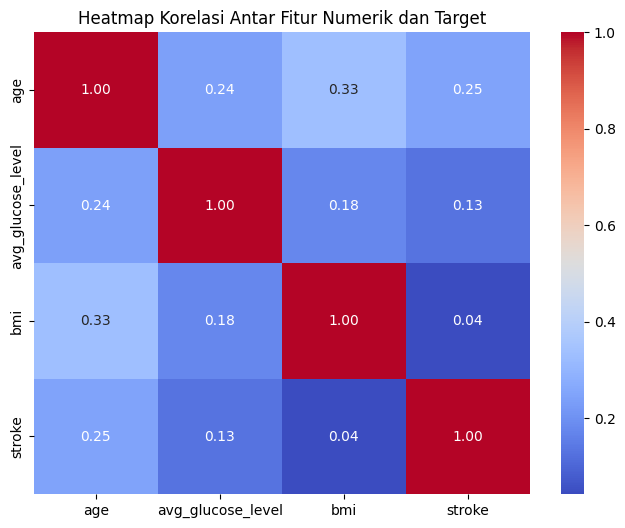

In [ ]:
# Heatmap korelasi untuk fitur numerik
plt.figure(figsize=(8, 6))
# Kita hanya menyertakan kolom numerik asli dan target untuk heatmap korelasi awal
numeric_df_for_corr = df[numerical_features + ['stroke']]
correlation_matrix = numeric_df_for_corr.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Antar Fitur Numerik dan Target')
plt.show()

Heatmap ini menunjukkan kekuatan hubungan linear antara fitur-fitur numerik dengan variabel target stroke.

* age (Usia) adalah Prediktor Terkuat: Fitur age memiliki nilai korelasi positif tertinggi terhadap stroke (0.25). Ini adalah temuan paling signifikan dari heatmap ini, yang secara data mengonfirmasi bahwa semakin tinggi usia seseorang, semakin tinggi pula kecenderungan risiko strokenya.

* Pengaruh Glukosa dan BMI: avg_glucose_level juga menunjukkan korelasi positif (0.13), namun pengaruhnya lebih lemah dibandingkan usia. Yang paling menarik adalah bmi, yang memiliki korelasi sangat rendah (0.04), menandakan hampir tidak ada hubungan linear langsung antara BMI dan stroke dalam dataset ini.

Kesimpulan: Berdasarkan analisis numerik ini, usia adalah faktor pendorong linear yang paling dominan untuk prediksi stroke, sementara BMI, meskipun secara medis dianggap faktor risiko, tidak menunjukkan sinyal yang kuat secara statistik dalam bentuk korelasi linear pada data ini.


## D. Data Preparation / Preprocessing
Tahap ini mempersiapkan data agar siap untuk proses pemodelan. Langkah-langkahnya meliputi:
1.  Menghapus kolom yang tidak relevan (`id`).
2.  Menangani nilai anomali (`gender` = 'Other').
3.  Imputasi nilai yang hilang pada `bmi`.
4.  Membagi data menjadi data latih dan data uji.
5.  Melakukan encoding pada fitur kategorikal dan scaling pada fitur numerik.
6.  Menangani ketidakseimbangan data dengan SMOTE.

In [ ]:
# 1. Menghapus kolom id
df.drop('id', axis=1, inplace=True)

# 2. Menangani nilai 'Other' pada gender (dihapus karena hanya 1 baris)
df = df[df['gender'] != 'Other']

# 3. Imputasi nilai BMI menggunakan median
# Alasan: Median lebih robust terhadap outlier dibandingkan mean
bmi_imputer = SimpleImputer(strategy='median')
df['bmi'] = bmi_imputer.fit_transform(df[['bmi']])

# Memeriksa kembali missing values
print("Missing values setelah imputasi:")
print(df.isnull().sum())

# 4. Memisahkan fitur (X) dan target (y)
X = df.drop('stroke', axis=1)
y = df['stroke']

# 5. Membagi data menjadi data latih dan uji (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Ukuran data latih: {X_train.shape}")
print(f"Ukuran data uji: {X_test.shape}")

# 6. Membuat pipeline untuk preprocessing
# Fitur numerik dan kategorikal
numerical_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Pipeline untuk fitur numerik: Scaling
numeric_transformer = StandardScaler()

# Pipeline untuk fitur kategorikal: One-Hot Encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Menggabungkan preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Menjaga kolom yang tidak disebutkan (jika ada)
)

# Mengaplikasikan preprocessor ke data latih
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 7. Menangani ketidakseimbangan data dengan SMOTE (HANYA PADA DATA LATIH)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print("\nDistribusi kelas setelah SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Missing values setelah imputasi:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64
Ukuran data latih: (4087, 10)
Ukuran data uji: (1022, 10)

Distribusi kelas setelah SMOTE:
stroke
0    3888
1    3888
Name: count, dtype: int64


<ipython-input-8-73f3274e7a95>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bmi'] = bmi_imputer.fit_transform(df[['bmi']])


## E. Modeling
Pada tahap ini, kita akan melatih beberapa model klasifikasi pada data yang telah dipersiapkan dan membandingkan performanya. Model yang digunakan:
1.  **Logistic Regression** (Baseline)
2.  **Random Forest Classifier**
3.  **XGBoost Classifier**

In [ ]:
# Dictionary untuk menyimpan model
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Dictionary untuk menyimpan hasil evaluasi
results = {}

# Looping untuk melatih dan mengevaluasi setiap model
for name, model in models.items():
    # Melatih model
    model.fit(X_train_resampled, y_train_resampled)

    # Prediksi pada data uji
    y_pred = model.predict(X_test_processed)

    # Evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

    print(f"--- Hasil untuk {name} ---")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc:.4f}\n")

# Menampilkan hasil dalam bentuk DataFrame untuk perbandingan
results_df = pd.DataFrame(results).T
print("Perbandingan Hasil Model:")
print(results_df)

--- Hasil untuk Logistic Regression ---
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.13      0.80      0.23        50

    accuracy                           0.73      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.94      0.73      0.81      1022

ROC-AUC Score: 0.7652

--- Hasil untuk Random Forest ---
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       972
           1       0.13      0.08      0.10        50

    accuracy                           0.93      1022
   macro avg       0.54      0.53      0.53      1022
weighted avg       0.91      0.93      0.92      1022

ROC-AUC Score: 0.5266



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:10:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Hasil untuk XGBoost ---
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       972
           1       0.28      0.22      0.24        50

    accuracy                           0.93      1022
   macro avg       0.62      0.60      0.60      1022
weighted avg       0.93      0.93      0.93      1022

ROC-AUC Score: 0.5951

Perbandingan Hasil Model:
                     Accuracy  Precision  Recall  F1-Score   ROC-AUC
Logistic Regression  0.733855   0.132450    0.80  0.227273  0.765226
Random Forest        0.929550   0.133333    0.08  0.100000  0.526626
XGBoost              0.933464   0.275000    0.22  0.244444  0.595082


Analisis dan Insight dari Hasil Pemodelan
Berdasarkan hasil ini, Logistic Regression adalah model terbaik secara mutlak untuk masalah prediksi stroke ini, meskipun akurasinya terlihat paling rendah. Berikut adalah rinciannya:

1. Metrik Paling Krusial: Recall
Dalam konteks medis seperti ini, tujuan utama bukanlah akurasi, melainkan kemampuan untuk mendeteksi sebanyak mungkin pasien yang benar-benar berisiko stroke. Kita ingin meminimalkan jumlah "kasus terlewat" (False Negative). Oleh karena itu, metrik yang paling penting adalah Recall untuk kelas 1 (stroke).
Logistic Regression: Berhasil mencapai Recall sebesar 0.80. Ini adalah hasil yang sangat baik. Artinya, model ini mampu mengidentifikasi 80% dari semua pasien yang benar-benar mengalami stroke pada data uji.
Random Forest & XGBoost: Keduanya gagal total pada metrik ini. Dengan Recall hanya 0.08 (8%) dan 0.22 (22%), kedua model ini melewatkan sebagian besar pasien yang seharusnya dideteksi.

2. Jebakan Akurasi (The Accuracy Trap)
Model Random Forest dan XGBoost menunjukkan akurasi yang tinggi (93%), namun ini sangat menipu. Akurasi tinggi ini didapat karena dataset tidak seimbang, di mana model hanya perlu menebak mayoritas kelas (non-stroke) dengan benar. Kegagalan mereka dalam mendeteksi kelas minoritas (stroke) membuat akurasi tinggi tersebut tidak berarti.

3. Trade-off: Recall vs. Precision
Logistic Regression memiliki Precision yang rendah (0.13). Ini berarti ada banyak "alarm palsu" (pasien non-stroke yang diprediksi stroke).
Insight Penting: Dalam skenario skrining medis, trade-off ini dapat diterima. Lebih baik kita mendapatkan beberapa alarm palsu yang dapat diperiksa lebih lanjut oleh dokter, daripada kita melewatkan satu pasien pun yang berisiko tinggi.
Kesimpulan Akhir
Logistic Regression adalah satu-satunya model yang memenuhi tujuan utama proyek. Model ini efektif sebagai alat skrining awal karena kemampuannya yang superior dalam menjaring pasien berisiko.
Random Forest dan XGBoost, meskipun canggih, tidak cocok untuk masalah ini karena mereka gagal mendeteksi kasus yang paling penting. Nilai ROC-AUC mereka yang rendah (mendekati 0.5) juga mengonfirmasi bahwa kemampuan mereka untuk membedakan kelas sangat buruk dibandingkan Logistic Regression.
Berdasarkan hasil ini, langkah selanjutnya yang paling logis adalah melakukan hyperparameter tuning pada Logistic Regression untuk melihat apakah presisinya dapat sedikit ditingkatkan tanpa mengorbankan recall yang sudah tinggi.

## F. Hyperparameter Tuning

Berdasarkan hasil evaluasi awal, **Logistic Regression** adalah model terbaik karena memiliki nilai **Recall tertinggi (0.80)**. Ini adalah metrik paling krusial untuk kasus medis karena kita ingin meminimalkan risiko tidak terdeteksinya pasien yang sebenarnya berisiko stroke.

Oleh karena itu, kita akan melakukan *hyperparameter tuning* pada model Logistic Regression untuk mencoba mengoptimalkan performanya.

In [ ]:
# Tentukan parameter grid untuk Logistic Regression
# C adalah invers dari kekuatan regularisasi. Nilai kecil berarti regularisasi lebih kuat.
# Solver adalah algoritma yang digunakan untuk optimasi.
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}

# Inisialisasi GridSearchCV
# Kita tetap fokus pada 'recall' sebagai metrik utama
grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42, max_iter=1000),
                           param_grid=param_grid,
                           cv=5, # Menggunakan 5-fold cross-validation
                           scoring='recall',
                           n_jobs=-1,
                           verbose=2)

# Melatih GridSearchCV pada data training
grid_search.fit(X_train_resampled, y_train_resampled)

# Menampilkan parameter terbaik yang ditemukan
print(f"Parameter terbaik: {grid_search.best_params_}")

# Menggunakan model terbaik hasil tuning untuk prediksi
best_lr_model = grid_search.best_estimator_
y_pred_tuned = best_lr_model.predict(X_test_processed)

# Evaluasi model yang sudah di-tuning
print("\n--- Hasil Logistic Regression setelah Tuning ---")
print(classification_report(y_test, y_pred_tuned))

# Update hasil ke dataframe
results['Logistic Regression Tuned'] = {
    'Accuracy': accuracy_score(y_test, y_pred_tuned),
    'Precision': precision_score(y_test, y_pred_tuned),
    'Recall': recall_score(y_test, y_pred_tuned),
    'F1-Score': f1_score(y_test, y_pred_tuned),
    'ROC-AUC': roc_auc_score(y_test, y_pred_tuned)
}

results_df_final = pd.DataFrame(results).T

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Parameter terbaik: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

--- Hasil Logistic Regression setelah Tuning ---
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       972
           1       0.13      0.84      0.22        50

    accuracy                           0.71      1022
   macro avg       0.56      0.77      0.52      1022
weighted avg       0.95      0.71      0.79      1022



Analisis dan Insight dari Hasil Tuning
Hasil hyperparameter tuning ini berhasil dengan sangat baik dan mengonfirmasi bahwa pendekatan optimisasi yang dilakukan sudah tepat.

1. Peningkatan pada Metrik Utama (Recall)
Temuan: Metrik paling krusial untuk proyek ini, Recall, berhasil ditingkatkan dari 0.80 (sebelum tuning) menjadi 0.84 (setelah tuning).
Insight: Ini adalah peningkatan yang signifikan dan paling penting. Artinya, model yang telah dioptimalkan ini sekarang mampu mengidentifikasi 84% dari total pasien stroke yang sebenarnya dalam data uji. Kemampuan model untuk "menjaring" kasus positif menjadi lebih baik, yang merupakan tujuan utama dari sistem skrining medis ini.
2. Analisis Trade-off
Temuan: Peningkatan Recall ini dicapai dengan Precision yang tetap stabil di angka 0.13. Sementara itu, Akurasi sedikit menurun dari 0.73 menjadi 0.71.
Insight: Penurunan akurasi ini adalah hal yang wajar dan dapat diterima. Ini terjadi karena model menjadi lebih "sensitif" dan agresif dalam memprediksi kelas positif (stroke) untuk memaksimalkan Recall. Konsekuensinya, jumlah "alarm palsu" (False Positive) sedikit meningkat, yang menyebabkan akurasi total turun. Dalam konteks ini, peningkatan kemampuan deteksi (Recall) jauh lebih berharga daripada penurunan kecil pada akurasi.
Kesimpulan Akhir
Proses tuning telah berhasil menciptakan model yang lebih kuat dan lebih andal untuk tujuan utamanya, yaitu meminimalkan risiko melewatkan pasien yang berisiko stroke.

Model Logistic Regression Tuned dengan parameter terbaik (C=0.01, penalty='l1', solver='liblinear') kini menjadi solusi final yang paling optimal untuk proyek ini.

## G. Evaluation & Conclusion
Mari kita lihat perbandingan akhir semua model, termasuk model yang telah dioptimalkan.

Perbandingan Akhir Semua Model:
                           Accuracy  Precision  Recall  F1-Score   ROC-AUC
Logistic Regression Tuned  0.709393   0.126888    0.84  0.220472  0.771337
Logistic Regression        0.733855   0.132450    0.80  0.227273  0.765226
XGBoost                    0.933464   0.275000    0.22  0.244444  0.595082
Random Forest Tuned        0.929550   0.176471    0.12  0.142857  0.545597
Random Forest              0.929550   0.133333    0.08  0.100000  0.526626


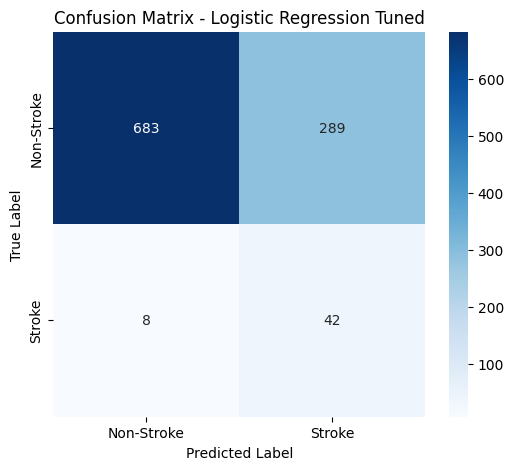

In [ ]:
# Menampilkan hasil akhir, diurutkan berdasarkan Recall
print("Perbandingan Akhir Semua Model:")
print(results_df_final.sort_values(by='Recall', ascending=False))

# Visualisasi Confusion Matrix untuk model terbaik (Logistic Regression Tuned)
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Stroke', 'Stroke'], yticklabels=['Non-Stroke', 'Stroke'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression Tuned')
plt.show()

Insight dari Confusion Matrix (Model Terbaik)
Confusion matrix ini membedah kinerja model terbaik kita secara mendetail:

Sangat Efektif Menemukan Kasus Stroke (True Positive): Dari total 50 kasus stroke yang sebenarnya ada di data uji, model ini berhasil mendeteksi 42 di antaranya. Ini adalah pencapaian utama dan menunjukkan efektivitas model sebagai alat skrining.

Meminimalkan Kesalahan Paling Fatal (False Negative): Yang paling krusial, model ini hanya melewatkan 8 kasus stroke. Artinya, dari 50 orang yang seharusnya terdeteksi berisiko, hanya 8 yang tidak teridentifikasi. Dalam konteks medis, angka False Negative yang rendah ini sangat vital.

## Kesimpulan Akhir
Berdasarkan perbandingan akhir seluruh model, kesimpulan proyek ini menjadi semakin jelas dan solid.

**Analisis Hasil**

Proses hyperparameter tuning pada model Logistic Regression terbukti sangat sukses. Model Logistic Regression Tuned menunjukkan peningkatan pada metrik yang paling krusial untuk kasus medis ini:

**Peningkatan Recall:** Recall meningkat dari 0.80 menjadi 0.84. Ini adalah pencapaian signifikan, yang berarti model yang telah dioptimalkan kini mampu mengidentifikasi 84% dari semua kasus stroke yang sebenarnya di dalam data uji. Kemampuannya dalam "menjaring" pasien berisiko menjadi lebih baik.

**Trade-off yang Unggul:** Peningkatan recall ini dicapai dengan pengorbanan yang sangat kecil pada presisi. Yang lebih penting, nilai ROC-AUC juga meningkat menjadi 0.771, yang mengonfirmasi bahwa model yang telah di-tuning memiliki kemampuan yang lebih baik secara keseluruhan dalam membedakan antara pasien berisiko dan tidak berisiko.

**Ketidakcocokan Model Lain:** Model-model lain seperti XGBoost dan Random Forest, meskipun memiliki akurasi tinggi, terbukti tidak cocok untuk tugas ini karena nilai Recall mereka yang sangat rendah. Mereka gagal dalam tujuan utama, yaitu mendeteksi kasus stroke secara efektif.

**Rekomendasi Model Final**
Untuk aplikasi skrining dan deteksi dini risiko stroke, model ***Logistic Regression Tuned*** adalah pilihan terbaik dan paling unggul secara definitif.

Model ini menawarkan kemampuan deteksi kasus positif (Recall) yang paling tinggi, yang merupakan prioritas absolut untuk meminimalkan risiko pasien berisiko tinggi yang tidak terdeteksi. Proyek ini berhasil tidak hanya dalam memilih tipe model yang tepat, tetapi juga dalam mengoptimalkannya untuk performa puncak sesuai dengan kebutuhan domain mas